In [1]:
from sklearn.manifold import TSNE
from src.main import *
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from matplotlib.lines import Line2D
from src.generate_graph import *
import sys

# Examples of graph repairing with OT

This notebook corresponds to the experiments reported in the supplementary of our paper published at AiStat 2021. 

## Generation of the graphs

Synthetic graphs are generated with networkx and the SBM model. 

In [12]:
# Define the graph that we want to try (g1, g2, g3 or g4)
probs, sizes, nb_classes, method = property_graph(graph='g1')

# Number of simulated graphs
trial = 1

# Display 
log = 'False'

# Algorithm used for the repair
algo = 'emd'

In [13]:
# Generate the graph and the associated node attribute s
g, s = get_graph_prot(sizes=sizes, probs=probs, number_class=nb_classes,
     choice=method)

# Compute the assortativity coefficient 
print('Assortativity coefficient on the original graph: %0.3f'% nx.attribute_assortativity_coefficient(g, 's'))

Assortativity coefficient on the original graph: 0.780


In [1]:
# Visualisation of the generated graph 

#Retrieve indexes of node in each group
s = np.fromiter(s.values(), dtype=int)
prot0 = np.where(s == 0)[0]
prot1 = np.where(s == 1)[0]

pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos=pos, node_size=80, nodelist=prot0, node_color='midnightblue', label='S = 0')
nx.draw_networkx_nodes(g, pos=pos, node_size=80, nodelist=prot1, node_color='gold', label='S = 1')
nx.draw_networkx_edges(g, pos=pos)
plt.legend(loc="upper left", scatterpoints=1, prop={'size': 15})
plt.tight_layout()
plt.show()

NameError: name 'np' is not defined

In [48]:
# Correct the graph with EMD
print("Correcting the graph with EMD")
new_adj, s, gamma, M = total_repair_emd(g,  metric='euclidean', 
                                        case='weighted', log=False)
new_g = nx.from_numpy_matrix(new_adj)

# Filter out the smallest weights to keep a reasonable density
list_edge = [(u, v) for (u, v, d) in new_g.edges(data=True) if d['weight'] < 0.5]
new_g.remove_edges_from (list_edge)

# Coefficient of assortativity on the repaired graph
dict_s = {i: s[i] for i in range(0, len(s))}
nx.set_node_attributes(new_g, dict_s, 's')
print('Assortativity coeffcient on the repaired (EMD) graph: %0.3f'
      % nx.attribute_assortativity_coefficient(new_g, 's'))

Correcting the graph with EMD
Assortativity coeffcient on the repaired (EMD) graph: -0.246


## Impact on the embeddings

We are now ready to illustrate the impact of the repairing on the node embeddings. 
To proceed, we use Node2Vec as an example.

In [50]:
# Learn embedding
print("Start learning embedding on the original graph")
embedding_origin, s_origin, modelO = emb_node2vec(g, s)

print("Start learning embedding on the repaired graph")
embedding_repair, s_repair, modelR = emb_node2vec(new_g, s)

Generating walks (CPU: 1):   2%|▏         | 2/100 [00:00<00:05, 19.07it/s]

Start learning embedding on the original graph


Generating walks (CPU: 1):   0%|          | 0/100 [00:00<?, ?it/s]

Start learning embedding on the repaired graph


Generating walks (CPU: 1): 100%|██████████| 100/100 [00:09<00:00, 11.08it/s]


In [65]:
# Compute the Representation Bias

clf = model_selection.KFold(n_splits=5, random_state=100, shuffle=True)
clf = LogisticRegression(solver='lbfgs')

results_origin = model_selection.cross_val_score(clf, embedding_origin, s_origin, cv=kfold,
                                                     scoring='roc_auc')

print("RB on the original graph is: %8.2f" % results_origin.mean())

results_repair = model_selection.cross_val_score(clf, embedding_repair, s_repair, cv=kfold,
                                                     scoring='roc_auc')

print("RB on the repaired graph is: %8.2f" % results_repair.mean())

RB on the original graph is:     0.94
RB on the repaired graph is:     0.47


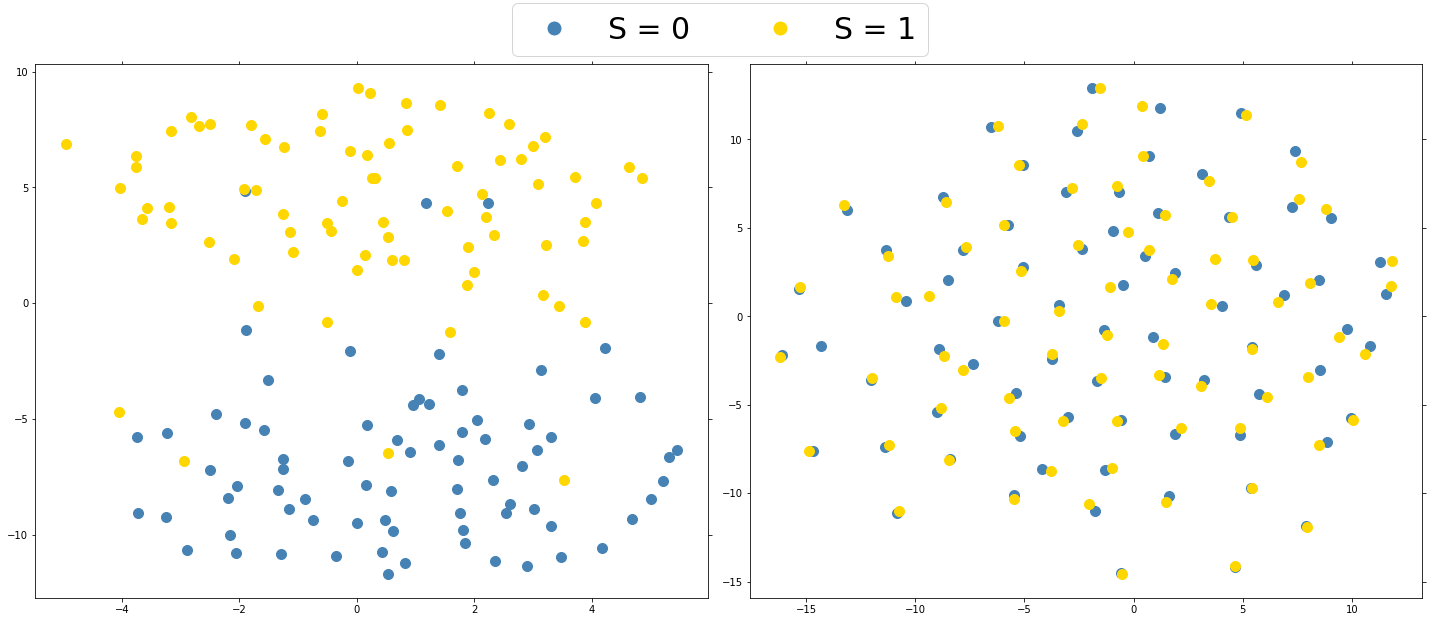

In [64]:
# Visualisation of the embeddings with TSNE
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

Y = tsne.fit_transform(embedding_origin)
Z = tsne.fit_transform(embedding_repair)
x1_coords = Y[:, 0]
y1_coords = Y[:, 1]

x2_coords = Z[:, 0]
y2_coords = Z[:, 1]

c = ['steelblue', 'gold']
k = 0
legend_elements = [Line2D([0], [0], marker='o', color='white', label='S = 0', markerfacecolor='steelblue', markersize=15),
        Line2D([0], [0], marker='o', color='white', label='S = 1',  markerfacecolor='gold', markersize=15),
      ]

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for g in np.unique(s_origin):
    i = np.where(s_origin == g)
    ax[0].scatter(x1_coords[i], y1_coords[i], color=c[k], s=100)
    k += 1
k = 0
ax[0].tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off',
                        labelleft='off')
for g in np.unique(s_repair):
    i = np.where(s_repair == g)
    ax[1].scatter(x2_coords[i], y2_coords[i], color=c[k], s=100)
    k += 1

fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.1),
                  ncol=3, fancybox=True, shadow=False, prop={'size': 30}, fontsize=30)
plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off',
                         labelleft='off')
plt.tight_layout()
       
plt.show()

## Correction of the graph with the laplacian regularizer

In [21]:
# Correct the graph with the laplacian regularizer
print("Correcting the graph with EMD")
new_adj, s, gamma, M = total_repair_emd(g,  metric='euclidean', 
                                        case='weighted', log=False)
new_g = nx.from_numpy_matrix(new_adj)

# Filter out the smallest weights to keep a reasonable density
list_edge = [(u, v) for (u, v, d) in new_g.edges(data=True) if d['weight'] <= 0.1]
new_g.remove_edges_from (list_edge)

# Coefficient of assortativity on the repaired graph
dict_s = {i: s[i] for i in range(0, len(s))}
nx.set_node_attributes(new_g, dict_s, 's')
print('Assortativity coeffcient on the repaired (EMD) graph: %0.3f'
      % nx.attribute_assortativity_coefficient(new_g, 's'))

Correcting the graph with EMD
Assortativity coeffcient on the repaired (EMD) graph: -0.246
